In [105]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import pandas_profiling
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import matplotlib.pyplot as plt

## Load the datasets

In [106]:
train_demographics=pd.read_csv('traindemographics.csv')
train_performance=pd.read_csv('trainperf.csv')
train_previous_loans=pd.read_csv('trainprevloans.csv')
test_previous_loan=pd.read_csv('testprevloans.csv')
test_demographics=pd.read_csv('testdemographics.csv')
test_performance=pd.read_csv('testperf.csv')
submit=pd.read_csv('SampleSubmission.csv')
print('finished loading csv')

finished loading csv


In [107]:
train_demographics[train_demographics['customerid'].duplicated(keep=False)].sort_values('customerid')
train_demographics = train_demographics.drop_duplicates(subset='customerid', keep='first', inplace=False)
train_demographics.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


## Merge the Datasets

In [108]:
train_demographics['set'] = 'train'
test_demographics['set'] = 'test'
train_performance['set'] = 'train'
test_performance['set'] = 'test'
train_previous_loans['set'] = 'train'
test_previous_loan['set'] = 'test'

In [112]:
Tdemographics=pd.concat([train_demographics,test_demographics] ,ignore_index = True, sort = False)
Tperfomance=pd.concat([train_performance,test_performance], ignore_index = True, sort = False)
Tprevious=pd.concat([train_previous_loans,test_previous_loan], ignore_index = True, sort = False)


In [113]:
print(Tdemographics.shape,Tperfomance.shape,Tprevious.shape)

(5821, 10) (5818, 11) (24090, 13)


In [114]:
Tprevious.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24090 entries, 0 to 24089
Data columns (total 13 columns):
customerid         24090 non-null object
systemloanid       24090 non-null int64
loannumber         24090 non-null int64
approveddate       24090 non-null object
creationdate       24090 non-null object
loanamount         24090 non-null float64
totaldue           24090 non-null float64
termdays           24090 non-null int64
closeddate         24090 non-null object
referredby         1351 non-null object
firstduedate       24090 non-null object
firstrepaiddate    24090 non-null object
set                24090 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 2.4+ MB


In [115]:
##convert date columns to date time

In [116]:
Tprevious.approveddate=pd.to_datetime(Tprevious.approveddate)

In [117]:
Tprevious.creationdate=pd.to_datetime(Tprevious.creationdate)

In [118]:
Tprevious.closeddate=pd.to_datetime(Tprevious.closeddate)

## Descritiptive analytics

#### Extract features from Tprevious

get profit per user

In [119]:
Tprevious['profit']=Tprevious['totaldue']-Tprevious['loanamount']

Get return days

In [120]:
Tprevious['return_days']=Tprevious.closeddate-Tprevious.approveddate
Tprevious['return_days']=Tprevious['return_days'].apply(lambda x:int(str(x)[:2]))

In [121]:
#extract remaining days

In [122]:
Tprevious['days_left']=Tprevious.termdays-Tprevious.return_days

In [123]:
#Totalprofit
Totalprofit=Tprevious.pivot_table(values='profit',index='customerid',aggfunc=sum)
Totalprofit.rename(columns={'profit':'Totalprofit'},inplace=True)


In [124]:

#Avgprofit
Avgprofit=Tprevious.pivot_table(values='profit',index='customerid',aggfunc=np.mean)
Avgprofit.rename(columns={'profit':'Avgprofit'},inplace=True)

In [125]:
#Avgloanamount
Avgloanamount=Tprevious.pivot_table(values='loanamount',index='customerid',aggfunc=np.mean)
Avgloanamount.rename(columns={'loanamount':'Avgloanamount'},inplace=True)

In [126]:

#Avgtermdays
Avgtermdays=Tprevious.pivot_table(values='termdays',index='customerid',aggfunc=np.mean)
Avgtermdays.rename(columns={'termdays':'Avgtermdays'},inplace=True)

In [127]:
#earlypayment
earlypayment=Tprevious.pivot_table(values='days_left',index='customerid',aggfunc=lambda x:(x>=0).sum())
earlypayment.rename(columns={'days_left':'earlypayment'},inplace=True)


In [128]:

#Avgdaysleft
Avgdaysleft=Tprevious.pivot_table(values='days_left',index='customerid',aggfunc=np.mean)
Avgdaysleft.rename(columns={'days_left':'Avgdaysleft'},inplace=True)

In [129]:
features=[Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment]

In [130]:
features=features[0].join(features[1:])

In [131]:
features.head()

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment
customerid,,,,,,
8a1088a0484472eb01484669e3ce4e0b,1500.0,1500.000000,10000.000000,15.000000,-7.00,0
8a1a1e7e4f707f8b014f797718316cad,19500.0,4875.000000,17500.000000,37.500000,6.25,3
8a1a32fc49b632520149c3b8fdf85139,16500.0,2357.142857,12857.142857,19.285714,1.00,6
8a1eb5ba49a682300149c3c068b806c7,32400.0,4050.000000,16250.000000,33.750000,5.25,8
8a1edbf14734127f0147356fdb1b1eb2,4500.0,2250.000000,10000.000000,22.500000,4.50,2


### Tperfomance

In [132]:
#create a new profit columns

In [133]:
Tperfomance['new_profit']=Tperfomance['totaldue']-Tperfomance['loanamount']

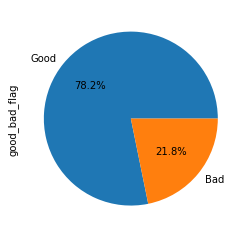

In [134]:
gb=Tperfomance.good_bad_flag.value_counts()
gb.plot(kind="pie",autopct='%1.1f%%')


In [135]:
Tperfomance.drop(columns=['systemloanid','creationdate','approveddate','totaldue'],inplace=True)

## Merge the datasets

In [136]:
#merge data which has attributes from previous loans to performance data
features=pd.merge(features.reset_index(),Tperfomance,how='outer',on='customerid')

In [137]:
#merge data which has attributes from previous & performance loans to demographics data
features=pd.merge(features,Tdemographics,on='customerid',how='inner')

In [138]:
features.columns

Index(['customerid', 'Totalprofit', 'Avgprofit', 'Avgloanamount',
       'Avgtermdays', 'Avgdaysleft', 'earlypayment', 'loannumber',
       'loanamount', 'termdays', 'referredby', 'good_bad_flag', 'set_x',
       'new_profit', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients', 'set_y'],
      dtype='object')

In [139]:
features=features.drop('set_y',axis=1)

In [140]:
features.head()

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,...,set_x,new_profit,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a1088a0484472eb01484669e3ce4e0b,1500.0,1500.000000,10000.000000,15.000000,-7.00,0.0,2,10000.0,15,...,train,1500.0,1989-11-09 00:00:00.000000,Savings,3.351667,6.657019,GT Bank,OJUELEGBA,Permanent,Primary
1,8a1a1e7e4f707f8b014f797718316cad,19500.0,4875.000000,17500.000000,37.500000,6.25,3.0,5,30000.0,60,...,train,9000.0,1979-10-18 00:00:00.000000,Other,3.395230,6.592191,Standard Chartered,NaN,Permanent,Graduate
2,8a1a32fc49b632520149c3b8fdf85139,16500.0,2357.142857,12857.142857,19.285714,1.00,6.0,8,20000.0,30,...,train,4500.0,1979-01-29 00:00:00.000000,Savings,3.306388,6.651843,GT Bank,MUSHIN BRANCH,Permanent,Graduate
3,8a1eb5ba49a682300149c3c068b806c7,32400.0,4050.000000,16250.000000,33.750000,5.25,8.0,9,30000.0,60,...,train,9000.0,1978-11-25 00:00:00.000000,Savings,3.426698,6.423048,First Bank,"17, SANUSI FAFUNWA STREET, VICTORIA ISLAND, LAGOS",Permanent,Secondary
4,8a1edbf14734127f0147356fdb1b1eb2,4500.0,2250.000000,10000.000000,22.500000,4.50,2.0,3,10000.0,15,...,train,1500.0,1978-04-07 00:00:00.000000,Savings,6.976132,4.801001,GT Bank,"AKUTE,LAGOS.",Permanent,Secondary


In [141]:
features.head()

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,...,set_x,new_profit,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a1088a0484472eb01484669e3ce4e0b,1500.0,1500.000000,10000.000000,15.000000,-7.00,0.0,2,10000.0,15,...,train,1500.0,1989-11-09 00:00:00.000000,Savings,3.351667,6.657019,GT Bank,OJUELEGBA,Permanent,Primary
1,8a1a1e7e4f707f8b014f797718316cad,19500.0,4875.000000,17500.000000,37.500000,6.25,3.0,5,30000.0,60,...,train,9000.0,1979-10-18 00:00:00.000000,Other,3.395230,6.592191,Standard Chartered,NaN,Permanent,Graduate
2,8a1a32fc49b632520149c3b8fdf85139,16500.0,2357.142857,12857.142857,19.285714,1.00,6.0,8,20000.0,30,...,train,4500.0,1979-01-29 00:00:00.000000,Savings,3.306388,6.651843,GT Bank,MUSHIN BRANCH,Permanent,Graduate
3,8a1eb5ba49a682300149c3c068b806c7,32400.0,4050.000000,16250.000000,33.750000,5.25,8.0,9,30000.0,60,...,train,9000.0,1978-11-25 00:00:00.000000,Savings,3.426698,6.423048,First Bank,"17, SANUSI FAFUNWA STREET, VICTORIA ISLAND, LAGOS",Permanent,Secondary
4,8a1edbf14734127f0147356fdb1b1eb2,4500.0,2250.000000,10000.000000,22.500000,4.50,2.0,3,10000.0,15,...,train,1500.0,1978-04-07 00:00:00.000000,Savings,6.976132,4.801001,GT Bank,"AKUTE,LAGOS.",Permanent,Secondary


We shall not drop GPS instead we normalize the outliers

In [142]:
#remove outliers in GPS 

In [143]:
##to check the percentile in longitude
print(np.nanpercentile(features.longitude_gps,98))
features.longitude_gps.median()

print(np.nanpercentile(features.longitude_gps,2))
features.longitude_gps.median()


##to check the percentile in lat
print(np.nanpercentile(features.latitude_gps,98))
features.latitude_gps.median()

print(np.nanpercentile(features.latitude_gps,2))
features.latitude_gps.median()


8.773581519999997
3.17528492
11.130042259999993
4.82342942


6.6211758000000005

In [144]:
## replacing min and max with 2 and 98 percentile
features.loc[features.longitude_gps <3.17528492, 'longitude_gps']= 3.17528492
features.loc[features.longitude_gps >8.7735815, 'longitude_gps']= 8.7735815
#fill the null values with median
features.longitude_gps.fillna(features.longitude_gps.mean(), inplace = True)

## replacing min and max with 2 and 98 percentile
features.loc[features.latitude_gps <4.82342942, 'latitude_gps']= 4.82342942
features.loc[features['latitude_gps'] > 11.130042 ,'latitude_gps']= 11.130042
features.latitude_gps.fillna(features.latitude_gps.mean(), inplace = True)

In [145]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5821 entries, 0 to 5820
Data columns (total 22 columns):
customerid                    5821 non-null object
Totalprofit                   5804 non-null float64
Avgprofit                     5804 non-null float64
Avgloanamount                 5804 non-null float64
Avgtermdays                   5804 non-null float64
Avgdaysleft                   5804 non-null float64
earlypayment                  5804 non-null float64
loannumber                    5821 non-null int64
loanamount                    5821 non-null float64
termdays                      5821 non-null int64
referredby                    771 non-null object
good_bad_flag                 4371 non-null object
set_x                         5821 non-null object
new_profit                    5821 non-null float64
birthdate                     5821 non-null object
bank_account_type             5821 non-null object
longitude_gps                 5821 non-null float64
latitude_gps        

### Function to calculate percentage of missing values

In [146]:

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

Check missing values

In [147]:
missing_values_table(features)

Your selected dataframe has 22 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
bank_branch_clients,5756,98.9
referredby,5050,86.8
level_of_education_clients,5025,86.3
good_bad_flag,1450,24.9
employment_status_clients,865,14.9
Totalprofit,17,0.3
Avgprofit,17,0.3
Avgloanamount,17,0.3
Avgtermdays,17,0.3
Avgdaysleft,17,0.3


We have 98.9% branch clients missing.We will drop that column because lat long represents location.We also drop reffered by since it does not have any effect on our prediction

In [148]:
features=features.drop(['bank_branch_clients','referredby'],axis=1)

In [149]:
#term days descriptive analysis

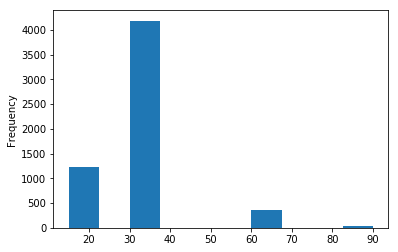

In [150]:
features.termdays.plot.hist(bins=10)

There is an outlier so we might revisit in tuning**

In [151]:
features.level_of_education_clients.value_counts()

Graduate         577
Secondary        118
Post-Graduate     90
Primary           11
Name: level_of_education_clients, dtype: int64

Level of education might be important so we dont drop the column, we fill na with unknown

In [152]:
features.level_of_education_clients.fillna("Unknown",inplace=True)

Employment status

In [153]:
features.employment_status_clients.value_counts()

Permanent        4208
Self-Employed     470
Student           189
Unemployed         79
Retired             8
Contract            2
Name: employment_status_clients, dtype: int64

In [154]:
features.employment_status_clients=features.employment_status_clients.replace({"Contract":"Unemployed","Retired":"Unemployed"})

In [155]:
features.employment_status_clients=features.employment_status_clients.fillna(features.employment_status_clients.mode()[0])

In [156]:
#Convert birthdate to datetime

In [157]:
features["birthdate"]=pd.to_datetime(features.birthdate)

In [158]:
features.head()

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,set_x,new_profit,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients
0,8a1088a0484472eb01484669e3ce4e0b,1500.0,1500.000000,10000.000000,15.000000,-7.00,0.0,2,10000.0,15,Bad,train,1500.0,1989-11-09,Savings,3.351667,6.657019,GT Bank,Permanent,Primary
1,8a1a1e7e4f707f8b014f797718316cad,19500.0,4875.000000,17500.000000,37.500000,6.25,3.0,5,30000.0,60,Good,train,9000.0,1979-10-18,Other,3.395230,6.592191,Standard Chartered,Permanent,Graduate
2,8a1a32fc49b632520149c3b8fdf85139,16500.0,2357.142857,12857.142857,19.285714,1.00,6.0,8,20000.0,30,Good,train,4500.0,1979-01-29,Savings,3.306388,6.651843,GT Bank,Permanent,Graduate
3,8a1eb5ba49a682300149c3c068b806c7,32400.0,4050.000000,16250.000000,33.750000,5.25,8.0,9,30000.0,60,Good,train,9000.0,1978-11-25,Savings,3.426698,6.423048,First Bank,Permanent,Secondary
4,8a1edbf14734127f0147356fdb1b1eb2,4500.0,2250.000000,10000.000000,22.500000,4.50,2.0,3,10000.0,15,Good,train,1500.0,1978-04-07,Savings,6.976132,4.823429,GT Bank,Permanent,Secondary


In [159]:
##create new column now

In [160]:
import datetime as dt
features['now'] = dt.datetime.now()



In [161]:
features['now'] = features['now'].apply(lambda x : x.year)

In [162]:
#change birth date to year

In [163]:
features['birthdate'] = features['birthdate'].apply(lambda x : x.year)

In [164]:
#create new column age 

In [165]:
features['age']=(features['now']-features['birthdate'])

In [166]:
##Drop birthdate we no longer need it

In [167]:
features=features.drop('birthdate',axis=1)

In [168]:
features.age=pd.cut(features.age,[0,13,31,51,100],labels=[1,2,3,4])

In [169]:
features.age=features.age.astype('int')

In [170]:
features.columns

Index(['customerid', 'Totalprofit', 'Avgprofit', 'Avgloanamount',
       'Avgtermdays', 'Avgdaysleft', 'earlypayment', 'loannumber',
       'loanamount', 'termdays', 'good_bad_flag', 'set_x', 'new_profit',
       'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients', 'now', 'age'],
      dtype='object')

In [171]:
features=features.drop('now',axis=1)

In [172]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5821 entries, 0 to 5820
Data columns (total 20 columns):
customerid                    5821 non-null object
Totalprofit                   5804 non-null float64
Avgprofit                     5804 non-null float64
Avgloanamount                 5804 non-null float64
Avgtermdays                   5804 non-null float64
Avgdaysleft                   5804 non-null float64
earlypayment                  5804 non-null float64
loannumber                    5821 non-null int64
loanamount                    5821 non-null float64
termdays                      5821 non-null int64
good_bad_flag                 4371 non-null object
set_x                         5821 non-null object
new_profit                    5821 non-null float64
bank_account_type             5821 non-null object
longitude_gps                 5821 non-null float64
latitude_gps                  5821 non-null float64
bank_name_clients             5821 non-null object
employment_status_

### Transform skewed numeric features

In [173]:
#log transform skewed numeric features:
numeric_feats = features.dtypes[(features.dtypes != "object") & (features.dtypes !='category')].index

skewed_feats = features[numeric_feats].apply(lambda x: pd.DataFrame.skew(x)) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

features[skewed_feats] = np.log1p(features[skewed_feats])


/home/dobvinci/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


In [174]:
features.dtypes.value_counts()

float64    12
object      7
int64       1
dtype: int64

### impute mode

In [175]:
catfeats_fillnamode=['good_bad_flag']
features.loc[:, catfeats_fillnamode] = \
    features[catfeats_fillnamode].fillna(features[catfeats_fillnamode].mode().iloc[0])

### impute mean

In [176]:
features['Totalprofit']=features.Totalprofit.fillna(0)

In [177]:
features['Avgprofit']=features.Avgprofit.fillna(0)

In [178]:
features['Avgloanamount']=features.Avgloanamount.fillna(0)

In [179]:
features['Avgtermdays']=features.Avgtermdays.fillna(0)

In [180]:
features['Avgdaysleft']=features.Avgdaysleft.fillna(0)

In [181]:
features['earlypayment']=features.earlypayment.fillna(0)

### Label Encoding function

In [182]:
features.head()

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,set_x,new_profit,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,age
0,8a1088a0484472eb01484669e3ce4e0b,7.313887,1500.000000,9.210440,15.000000,-7.00,0.000000,1.098612,9.210440,2.772589,Bad,train,7.313887,Savings,1.470559,2.035623,GT Bank,Permanent,Primary,2
1,8a1a1e7e4f707f8b014f797718316cad,9.878221,4875.000000,9.770013,37.500000,6.25,1.386294,1.791759,10.308986,4.110874,Good,train,9.105091,Other,1.480520,2.027120,Standard Chartered,Permanent,Graduate,3
2,8a1a32fc49b632520149c3b8fdf85139,9.711176,2357.142857,9.461733,19.285714,1.00,1.945910,2.197225,9.903538,3.433987,Good,train,8.412055,Savings,1.460100,2.034947,GT Bank,Permanent,Graduate,3
3,8a1eb5ba49a682300149c3c068b806c7,10.385945,4050.000000,9.695910,33.750000,5.25,2.197225,2.302585,10.308986,4.110874,Good,train,9.105091,Savings,1.487654,2.004590,First Bank,Permanent,Secondary,3
4,8a1edbf14734127f0147356fdb1b1eb2,8.412055,2250.000000,9.210440,22.500000,4.50,1.098612,1.386294,9.210440,2.772589,Good,train,7.313887,Savings,2.076454,1.761889,GT Bank,Permanent,Secondary,3


In [183]:
features.columns

Index(['customerid', 'Totalprofit', 'Avgprofit', 'Avgloanamount',
       'Avgtermdays', 'Avgdaysleft', 'earlypayment', 'loannumber',
       'loanamount', 'termdays', 'good_bad_flag', 'set_x', 'new_profit',
       'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients', 'age'],
      dtype='object')

In [184]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#New variable for outlet
var_mod = ["good_bad_flag","bank_account_type", "bank_account_type", "bank_name_clients" ,"employment_status_clients" ,"level_of_education_clients"]

for i in var_mod:
    features[i] = le.fit_transform(features[i])

### Seperate the datasets

In [185]:
#Divide into test and train:
train = features.loc[features['set_x']=="train"]
test = features.loc[features['set_x']=="test"]
#Drop unnecessary columns:
#features.drop(['SalePrice','set'],axis=1,inplace=True)


In [186]:
train.head()

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,set_x,new_profit,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,age
0,8a1088a0484472eb01484669e3ce4e0b,7.313887,1500.000000,9.210440,15.000000,-7.00,0.000000,1.098612,9.210440,2.772589,0,train,7.313887,2,1.470559,2.035623,6,0,2,2
1,8a1a1e7e4f707f8b014f797718316cad,9.878221,4875.000000,9.770013,37.500000,6.25,1.386294,1.791759,10.308986,4.110874,1,train,9.105091,1,1.480520,2.027120,11,0,0,3
2,8a1a32fc49b632520149c3b8fdf85139,9.711176,2357.142857,9.461733,19.285714,1.00,1.945910,2.197225,9.903538,3.433987,1,train,8.412055,2,1.460100,2.034947,6,0,0,3
3,8a1eb5ba49a682300149c3c068b806c7,10.385945,4050.000000,9.695910,33.750000,5.25,2.197225,2.302585,10.308986,4.110874,1,train,9.105091,2,1.487654,2.004590,5,0,3,3
4,8a1edbf14734127f0147356fdb1b1eb2,8.412055,2250.000000,9.210440,22.500000,4.50,1.098612,1.386294,9.210440,2.772589,1,train,7.313887,2,2.076454,1.761889,6,0,3,3


In [187]:
test.head()

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,loannumber,loanamount,termdays,good_bad_flag,set_x,new_profit,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,age
6,8a28afc7474813a40147639ec637156b,10.401258,3290.000000,9.787010,31.5,6.000000,2.302585,2.484907,10.126671,3.433987,1,test,7.824446,1,1.469902,2.015717,6,0,4,3
12,8a3735d5518aba7301518ac34413010d,9.798183,3000.000000,9.364577,27.5,13.333333,1.791759,2.079442,9.903538,3.433987,1,test,8.412055,1,1.477551,2.031275,6,0,0,3
18,8a76e7d443e6e97c0143ed099d102b1d,8.006701,1500.000000,9.210440,15.0,1.500000,1.098612,1.945910,9.903538,3.433987,1,test,8.412055,1,1.474281,2.020469,17,0,4,3
21,8a818823525dceef01525deda2480384,10.596035,4441.666667,9.846382,40.0,0.777778,1.945910,2.397895,10.596660,4.110874,1,test,8.987322,2,2.086258,1.767613,5,1,0,3
23,8a818926522ea5ef01523aff15c37482,8.699681,3000.000000,9.210440,30.0,-10.500000,0.000000,1.386294,9.903538,3.433987,1,test,8.412055,2,2.041627,1.975320,1,0,3,3


In [188]:
test.drop(['set_x'],axis=1,inplace=True)
train.drop(['set_x'],axis=1,inplace=True)
#Export files as modified versions:
train.to_csv("cleaned/train_modified.csv",index=False)
test.to_csv("cleaned/test_modified.csv",index=False)

/home/dobvinci/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Modelling

In [189]:
train_df = pd.read_csv('cleaned/train_modified.csv')
test_df = pd.read_csv('cleaned/test_modified.csv')

#Define target and ID columns:
target = 'good_bad_flag'


In [190]:
train_ids = train_df['customerid']
test_ids = test_df['customerid']

In [191]:
train_df.drop(['customerid'],axis=1,inplace=True)

In [192]:
test_df.drop(['customerid',target],axis=1,inplace=True)

In [193]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 17 columns):
Totalprofit                   1450 non-null float64
Avgprofit                     1450 non-null float64
Avgloanamount                 1450 non-null float64
Avgtermdays                   1450 non-null float64
Avgdaysleft                   1450 non-null float64
earlypayment                  1450 non-null float64
loannumber                    1450 non-null float64
loanamount                    1450 non-null float64
termdays                      1450 non-null float64
new_profit                    1450 non-null float64
bank_account_type             1450 non-null int64
longitude_gps                 1450 non-null float64
latitude_gps                  1450 non-null float64
bank_name_clients             1450 non-null int64
employment_status_clients     1450 non-null int64
level_of_education_clients    1450 non-null int64
age                           1450 non-null int64
dtypes: float64(12)

We align the dataframes by the columns. This ensures we have the same columns in the training and testing datasets.

In [194]:
train_df, test_df = train_df.align(test, join = 'inner', axis = 1)
print('Training shape: ', train_df.shape)
print('Testing shape: ', test_df.shape)

Training shape:  (4371, 18)
Testing shape:  (1450, 18)


In [195]:
train_df.columns

Index(['Totalprofit', 'Avgprofit', 'Avgloanamount', 'Avgtermdays',
       'Avgdaysleft', 'earlypayment', 'loannumber', 'loanamount', 'termdays',
       'good_bad_flag', 'new_profit', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients', 'age'],
      dtype='object')

In [196]:
X=train_df.drop('good_bad_flag',axis=1)
y=train_df['good_bad_flag']
x_test=test_df

In [197]:
x_train,x_valid,y_train,y_valid=train_test_split(X, y, test_size=0.2,random_state=7)

### Function to measure the models performance

In [198]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,roc_auc_score,classification_report,roc_auc_score,roc_curve,auc

#Model function
def model(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):

    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    print (algorithm)
    
    print ("Accuracy score : ", accuracy_score(predictions,dtest_Y))
    print ("Recall score   : ", recall_score(predictions,dtest_Y))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    
    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    #ax.set_facecolor("k")


In [199]:
rdmforest = RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy score :  0.7794285714285715
Recall score   :  0.8358008075370121
classification report :
               precision    recall  f1-score   support

           0       0.33      0.46      0.39       132
           1       0.90      0.84      0.87       743

   micro avg       0.78      0.78      0.78       875
   macro avg       0.62      0.65      0.63       875
weighted avg       0.81      0.78      0.79       875



/home/dobvinci/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


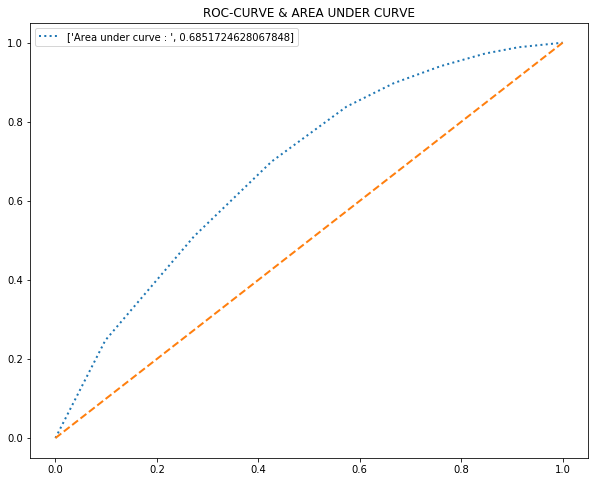

In [200]:
model(rdmforest,x_train,y_train,x_valid,y_valid,x_train.columns)

In [201]:
gdboost = GradientBoostingClassifier()

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy score :  0.7954285714285714
Recall score   :  0.8170580964153276
classification report :
               precision    recall  f1-score   support

           0       0.19      0.53      0.28        66
           1       0.96      0.82      0.88       809

   micro avg       0.80      0.80      0.80       875
   macro avg       0.57      0.67      0.58       875
weighted avg       0.90      0.80      0.84       875



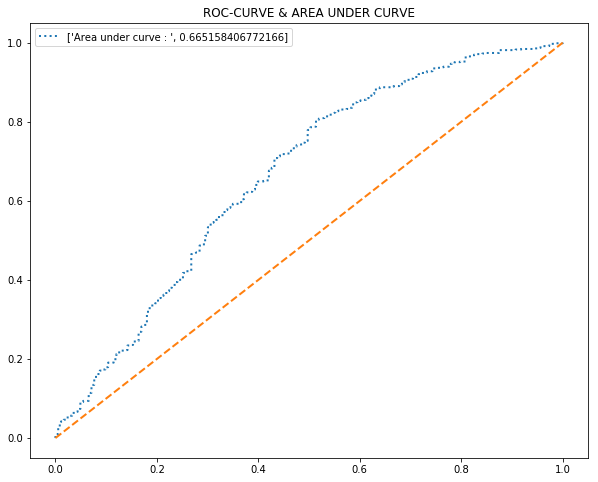

In [202]:
model(gdboost,x_train,y_train,x_valid,y_valid,x_train.columns)

In [203]:
gnb=GaussianNB()

GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy score :  0.7017142857142857
Recall score   :  0.8270106221547799
classification report :
               precision    recall  f1-score   support

           0       0.38      0.32      0.35       216
           1       0.79      0.83      0.81       659

   micro avg       0.70      0.70      0.70       875
   macro avg       0.58      0.57      0.58       875
weighted avg       0.69      0.70      0.69       875



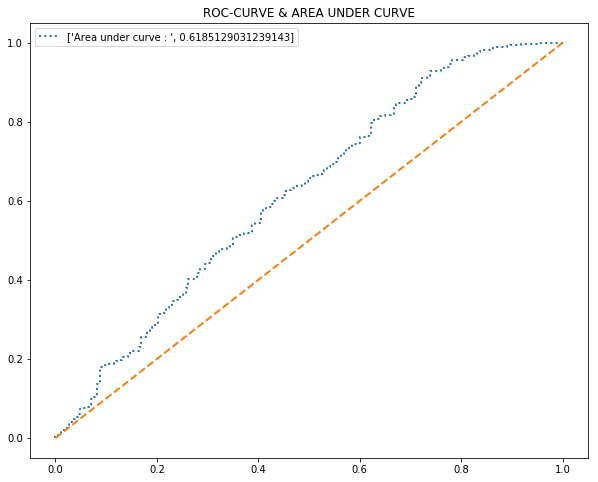

In [204]:
model(gnb,x_train,y_train,x_valid,y_valid,x_train.columns)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy score :  0.7954285714285714
Recall score   :  0.8170580964153276
classification report :
               precision    recall  f1-score   support

           0       0.19      0.53      0.28        66
           1       0.96      0.82      0.88       809

   micro avg       0.80      0.80      0.80       875
   macro avg       0.57      0.67      0.58       875
weighted avg       0.90      0.80      0.84       875



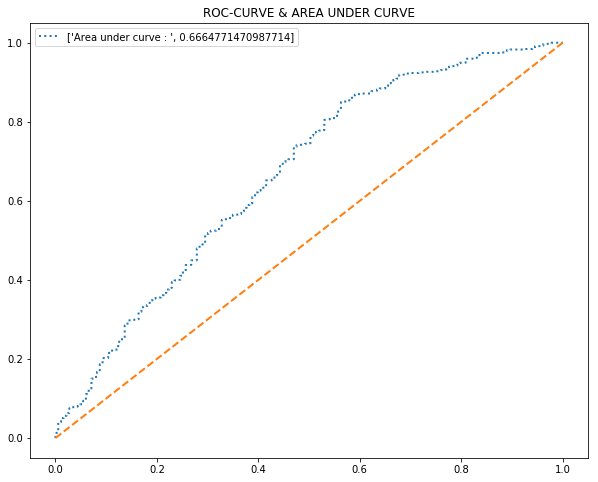

In [205]:
xgb = XGBClassifier()
model(xgb,x_train,y_train,x_valid,y_valid,x_train.columns)

In [209]:
test_df.drop('good_bad_flag',inplace=True,axis=1)

In [210]:
submission = pd.DataFrame()
submission['customerid'] = test_ids
submission['Good_Bad_flag'] = xgb.predict(test_df).astype('int')
submission.to_csv('submission_vnjagi.csv', index=False)

## My score was 0.211724137931034 Ranked 16th